## Import modules

In [1]:
import os
import os.path as osp
import sys
from random import randrange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import datetime
import pytz
import torch
import torch.nn as nn
# from fhirpy import SyncFHIRClient
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Flatten, Embedding, Multiply, Concatenate, Input
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
# from keras.optimizers import adam_v2 # Error: cannot import name 'adam_v2' from 'keras.optimizers'
from keras.optimizers import Adam
import csv
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def fix_all_seeds(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
fix_all_seeds(2021)

## Data

In [2]:
df_data = pd.read_csv("./input/data.csv")
df_data = df_data.rename(columns={"concave points_mean":"concave.points_mean", "concave points_se": "concave.points_se", "concave points_worst":"concave.points_worst", "diagnosis":"label"})
df_data = df_data.drop(["Unnamed: 32"], axis=1)

station_list = ["uka", "ukg", "ukk", "ukl", "imise", "mittweida"]
station_dfs = [pd.read_csv("./input/{}.csv".format(station)).rename(columns={"patient_id":"id"}) for station in station_list]
final_test_df = pd.read_csv("./input/final_test.csv").rename(columns={"patient_id":"id"})
for idx in range(len(station_list)):
    station_dfs[idx]["id"] = station_dfs[idx]["id"].map(lambda x: int(x[6:]))
    station_dfs[idx] = pd.merge(df_data, station_dfs[idx], on='id', how='right')
final_test_df["id"] = final_test_df["id"].map(lambda x: int(x[6:]))
final_test_df = pd.merge(df_data, final_test_df, on='id', how='right')

In [3]:
print(len(final_test_df) + len(station_dfs[0]) + len(station_dfs[1]) + len(station_dfs[2]) + len(station_dfs[3]) + len(station_dfs[4]) + len(station_dfs[5]))
print(len(df_data))
print(len(final_test_df))
print([len(station_dfs[idx]) for idx in range(len(station_dfs))])

569
569
228
[56, 56, 56, 56, 61, 56]


## EDA

35 21
35 21
35 21
35 21
39 22
35 21


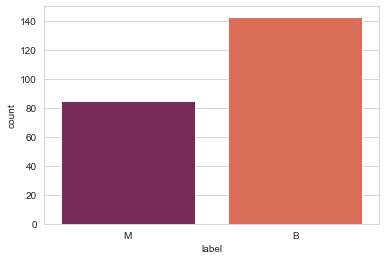

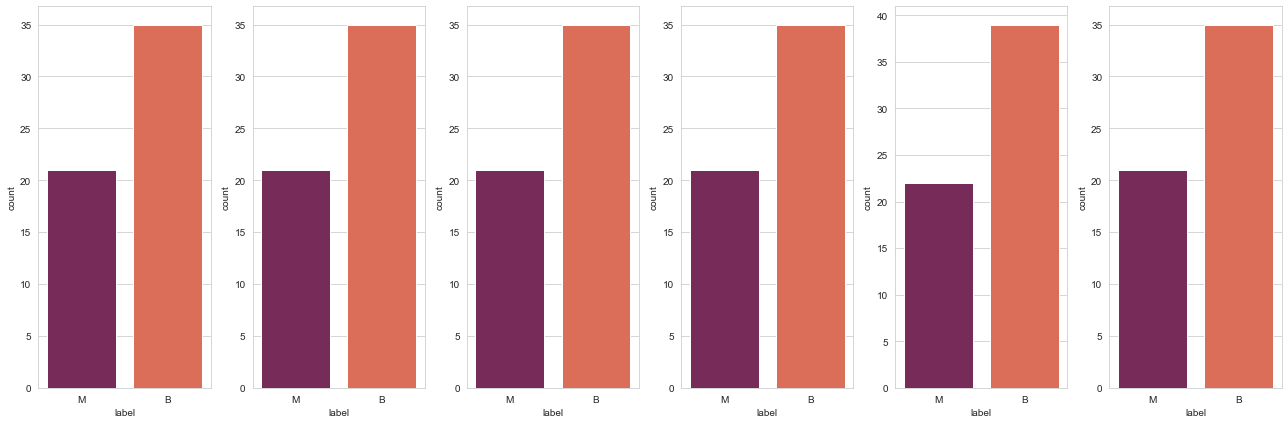

In [4]:
sns.set_style('whitegrid')
plt.figure()
sns.countplot(x="label", data=final_test_df, palette='rocket');

plt.figure(figsize=(18,6))
for idx in range(len(station_dfs)):
    plt.subplot(1,6,idx+1)
    B, M = station_dfs[idx]["label"].value_counts()
    print(B, M)
    sns.countplot(x="label", data=station_dfs[idx], palette='rocket');
    plt.tight_layout()

In [5]:
X_FEATURES = ['radius_mean', 'texture_mean', 'perimeter_mean',
              'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
              'concave.points_mean', 'symmetry_mean', 'fractal_dimension_mean',
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
              'compactness_se', 'concavity_se', 'concave.points_se', 'symmetry_se',
              'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst',
              'compactness_worst', 'concavity_worst', 'concave.points_worst',
              'symmetry_worst', 'fractal_dimension_worst']
Y_FEATURE = 'label'
df_mean_X = []
df_std_X = []

for idx in range(len(station_list)):
    df_mean_X.append(np.mean(station_dfs[idx][X_FEATURES], axis=0).to_numpy())
    df_std_X.append(np.std(station_dfs[idx][X_FEATURES], axis=0).to_numpy())

df_mean_X.append(np.mean(final_test_df[X_FEATURES], axis=0).to_numpy())
df_std_X.append(np.std(final_test_df[X_FEATURES], axis=0).to_numpy())
df_mean_X = pd.DataFrame(df_mean_X, columns=X_FEATURES)
df_std_X = pd.DataFrame(df_std_X, columns=X_FEATURES)
df_mean_X["station"] = pd.Series(station_list+["final test"])
df_std_X["station"] = pd.Series(station_list+["final test"])

In [6]:
df_mean_X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,station
0,13.731571,19.582857,89.354107,608.767857,0.094890,0.104666,0.082391,0.045645,0.177461,0.063306,...,26.149643,103.899643,812.069643,0.133315,0.269866,0.269384,0.113831,0.276321,0.086851,uka
1,14.397768,18.889821,93.583929,671.785714,0.096442,0.104018,0.088604,0.049828,0.180682,0.062323,...,25.928929,109.231786,907.616071,0.135511,0.269095,0.296277,0.122032,0.293105,0.085412,ukg
2,14.210804,19.831964,92.376071,662.580357,0.094050,0.098760,0.077473,0.045377,0.178232,0.062172,...,25.904821,108.191429,883.089286,0.125765,0.231277,0.229873,0.104961,0.277905,0.080141,ukk
3,14.041125,19.713036,91.210000,648.178571,0.094190,0.100675,0.080000,0.045794,0.179416,0.062446,...,26.035893,106.121786,877.585714,0.128090,0.237016,0.238041,0.108172,0.283812,0.081378,ukl
4,13.744197,18.907869,89.610820,617.924590,0.098141,0.106430,0.097691,0.052405,0.185074,0.064454,...,25.281967,104.514426,821.937705,0.136072,0.253771,0.284095,0.120542,0.306526,0.087015,imise


In [7]:
df_std_X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave.points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave.points_worst,symmetry_worst,fractal_dimension_worst,station
0,2.926020,4.843530,20.201886,277.122168,0.014855,0.060492,0.070533,0.033302,0.026809,0.007918,...,7.397978,28.650615,450.418996,0.027678,0.192328,0.207938,0.066242,0.046357,0.019563,uka
1,3.228776,4.378659,21.740257,314.734701,0.013174,0.043006,0.066657,0.032307,0.020013,0.006693,...,6.753764,30.197674,522.003759,0.023050,0.159774,0.206911,0.059225,0.056542,0.021350,ukg
2,3.526905,4.576257,24.442783,329.270842,0.013011,0.052094,0.075330,0.039270,0.025404,0.005878,...,6.148746,34.081328,507.822445,0.018150,0.163689,0.198969,0.068884,0.052208,0.013139,ukk
3,3.583369,4.815006,24.590153,348.758869,0.012611,0.048429,0.067751,0.036131,0.027967,0.007328,...,6.378750,33.516174,587.667935,0.018573,0.132725,0.163827,0.059545,0.046832,0.015148,ukl
4,3.348225,4.023645,23.147326,319.766652,0.012573,0.047897,0.085303,0.038901,0.029158,0.007371,...,5.833279,31.048951,499.600696,0.021545,0.137068,0.192088,0.062331,0.075538,0.017028,imise


## Define model

In [8]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.output_layer = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        out = self.output_layer(self.sigmoid(self.hidden_layer(x)))
        return out

def train(X_train, y_train, model, criterion, optimizer):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).long()
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()


def valid(X_test, y_test, model, criterion):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).long()
    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    _, predicted = torch.max(outputs, 1)
    cm = confusion_matrix(targets.numpy(), predicted.numpy())
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    with np.errstate(divide='ignore', invalid='ignore'):
        val_acc = (tp + tn) / (tp + fp + fn + tn)
        val_precesion = tp / (tp + fp)
        val_recall = tp / (tp + fn)
        val_f1_score = 2 * tp / (2 * tp + fn + fp)
    return val_loss.item(), val_acc, val_precesion, val_recall, val_f1_score

In [9]:
losses = []
accuracies = []
iteration_checks = []

def shuffle_list(lst):
    lst2 = lst.copy()
    random.shuffle(lst2)
    return lst2


def train_synthetic(data, iterations, batch_size, interval, number_of_row):
    Xtrainnew = data
    mydata = Xtrainnew.values.tolist()
    ytrain = []
    for j in mydata:
        ytrain.append(j[0])
    Xtrainnew = pd.DataFrame(data=mydata)
    Ytrainnew = np.array(ytrain)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(Xtrainnew)
    Xtrain = scaled
    ytrain = Ytrainnew
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        ids = np.random.randint(0, Xtrain.shape[0], batch_size)
        imgs = Xtrain[ids]
        labels = ytrain[ids]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = gen_v.predict([z, labels])

        dloss_real = dis_v.train_on_batch([imgs, labels], real)
        dloss_fake = dis_v.train_on_batch([gen_imgs, labels], fake)

        dloss, accuracy = 0.5 * np.add(dloss_real, dloss_fake)

        z = np.random.normal(0, 1, (batch_size, 100))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        gloss = gan_v.train_on_batch([z, labels], real)

        if (iteration + 1) % interval == 0:
            losses.append((dloss, gloss))
            accuracies.append(100.0 * accuracy)
            iteration_checks.append(iteration + 1)

            print("%d [D loss: %f , acc: %.2f] [G loss: %f]" %
                  (iteration + 1, dloss, 100.0 * accuracy, gloss))
    return show_data(gen_v, scaler, number_of_row)


def savelist2csv(mynamefile, mylist):
    with open('./' + mynamefile, 'w') as myfile:
        wr = csv.writer(myfile, delimiter='\n', quoting=csv.QUOTE_MINIMAL)
        wr.writerow(mylist)


def show_data(gen, scaler, number_of_rows):
    z = np.random.normal(0, 1, (number_of_rows, 100))
    labels = np.random.randint(2, size=number_of_rows)
    gen_imgs = gen.predict([z, labels])
    gen_imgs = scaler.inverse_transform(gen_imgs)
    for index in range(0, number_of_rows):
        gen_imgs[index] = np.around(gen_imgs[index], 4)
        gen_imgs[index][0] = np.around(gen_imgs[index][0], 0)
    return gen_imgs


def build_gen(zdim):
    model = Sequential()
    model.add(Dense(31, input_dim=zdim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1 * 31, activation='tanh'))
    return model


def build_cgen(zdim):
    z = Input(shape=(zdim,))
    lable = Input(shape=(1,), dtype='int32')
    lable_emb = Embedding(num_classes, zdim, input_length=1)(lable)
    lable_emb = Flatten()(lable_emb)
    joined_rep = Multiply()([z, lable_emb])
    gen_v = build_gen(zdim)
    c_img = gen_v(joined_rep)
    return Model([z, lable], c_img)


def build_dis(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(31))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model


def build_cdis(img_shape):
    img = Input(shape=(img_cols,))
    lable = Input(shape=(1,), dtype='int32')
    lable_emb = Embedding(num_classes, np.prod((31)), input_length=1)(lable)
    lable_emb = Flatten()(lable_emb)
    # lable_emb=Reshape(img_shape)(lable_emb)
    concate_img = Concatenate(axis=-1)([img, lable_emb])
    dis_v = build_dis((img_rows, img_cols * 2))
    classification = dis_v(concate_img)
    return Model([img, lable], classification)


def build_cgan(genrator, discriminator):
    z = Input(shape=(zdim,))
    lable = Input(shape=(1,), dtype='int32')
    f_img = genrator([z, lable])
    classification = discriminator([f_img, lable])
    model = Model([z, lable], classification)
    return model

img_rows = 1
img_cols = 31
img_shape = (img_rows, img_cols)
zdim = 100
num_classes = 2
dis_v = build_cdis(img_shape)
dis_v.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
gen_v = build_cgen(zdim)
dis_v.trainable = False
gan_v = build_cgan(gen_v, dis_v)
gan_v.compile(loss='binary_crossentropy',optimizer=Adam())

def generation_synthetic_data(data):
    labels_training = data[Y_FEATURE]
    labels_training = labels_training.map(dict(M=1, B=0))
    features_training = data[X_FEATURES]
    # merge the data to one dataframe again for the training of cGAN
    train_data_synthetic = pd.concat([labels_training, features_training], axis=1, join='inner')
    # main method of the training of the cGAN as explained above
    synthetic_data = train_synthetic(data=train_data_synthetic, iterations=5000, batch_size=128, interval=1000,
                                     number_of_row=data.shape[1])
    # the random generation for the patient-id, gender and birthday
    # label needs to be transformed to the original values
    label_synthetic = []
    patient_id_synthetic = []
    patient_gender_synthetic = []
    patient_birthday_synthetic = []

    # very simple approach for the missing data generation, note: can be improved
    for row in range(0, len(synthetic_data)):
        synthetic_data_row = synthetic_data[row,]
        if (synthetic_data_row[0] == 1):
            label_synthetic.append("M")
        else:
            label_synthetic.append("B")
        patient_id_synthetic.append(("bbmri" + str(row)))
        p_g = "female"
        p_b = "01.01.2000"
        patient_birthday_synthetic.append(p_b)
        patient_gender_synthetic.append(p_g)

    # use the X_FEATURES of the synthetic data
    synthetic_data = synthetic_data[:, 1:31]

    # write everything in a dataframe for representation
    synthetic_df = pd.DataFrame(np.c_[
                                    patient_id_synthetic, patient_gender_synthetic, patient_birthday_synthetic, synthetic_data, label_synthetic],
                                columns=["patient_id", "gender", "birthDate", "radius_mean", "texture_mean",
                                         "perimeter_mean", "area_mean", "smoothness_mean", "compactness_mean",
                                         "concavity_mean", "concave.points_mean", "symmetry_mean",
                                         "fractal_dimension_mean",
                                         "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
                                         "compactness_se", "concavity_se", "concave.points_se", "symmetry_se",
                                         "fractal_dimension_se", "radius_worst", "texture_worst", "perimeter_worst",
                                         "area_worst", "smoothness_worst", "compactness_worst", "concavity_worst",
                                         "concave.points_worst", "symmetry_worst", "fractal_dimension_worst", "label"])
    return synthetic_df

synthetic_dfs =  [generation_synthetic_data(station_dfs[idx]) for idx in range(len(station_list))] 

1000 [D loss: 0.626741 , acc: 87.11] [G loss: 0.816488]
2000 [D loss: 0.765658 , acc: 19.53] [G loss: 0.630239]
3000 [D loss: 0.758578 , acc: 30.86] [G loss: 0.624956]
4000 [D loss: 0.718428 , acc: 34.77] [G loss: 0.652393]
5000 [D loss: 0.658294 , acc: 66.80] [G loss: 0.750383]
1000 [D loss: 0.706832 , acc: 41.80] [G loss: 0.628371]
2000 [D loss: 0.657278 , acc: 67.19] [G loss: 0.760189]
3000 [D loss: 0.685382 , acc: 46.09] [G loss: 0.666448]
4000 [D loss: 0.693095 , acc: 49.22] [G loss: 0.694801]
5000 [D loss: 0.624322 , acc: 89.06] [G loss: 0.835621]
1000 [D loss: 0.566536 , acc: 96.88] [G loss: 0.889278]
2000 [D loss: 0.686005 , acc: 51.17] [G loss: 0.750917]
3000 [D loss: 0.712900 , acc: 42.58] [G loss: 0.627694]
4000 [D loss: 0.711322 , acc: 40.23] [G loss: 0.698101]
5000 [D loss: 0.693902 , acc: 52.34] [G loss: 0.669029]
1000 [D loss: 0.711593 , acc: 46.48] [G loss: 0.689649]
2000 [D loss: 0.760938 , acc: 32.81] [G loss: 0.602635]
3000 [D loss: 0.715014 , acc: 48.05] [G loss: 0.

## Prepare Final Test Dataset

In [10]:
test_scaler = StandardScaler()
X_test = final_test_df[X_FEATURES]
y_test = final_test_df[Y_FEATURE]
X_test = test_scaler.fit_transform(X_test)
y_test.replace(to_replace=dict(M=1, B=0), inplace=True)
y_test = y_test.to_numpy()

## Single Site Training

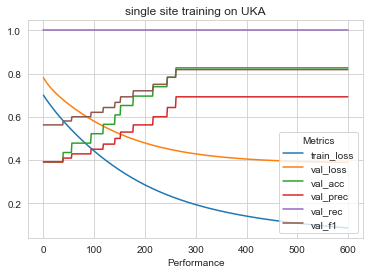

single site training on UKA
test loss 0.3959694802761078
test_acc 0.8377192982456141
test_prec 0.6967213114754098
test_rec 1.0
test_f1 0.821256038647343




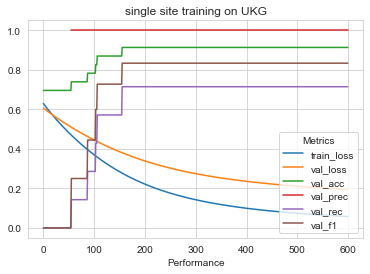

single site training on UKG
test loss 0.18424832820892334
test_acc 0.9473684210526315
test_prec 0.9866666666666667
test_rec 0.8705882352941177
test_f1 0.925




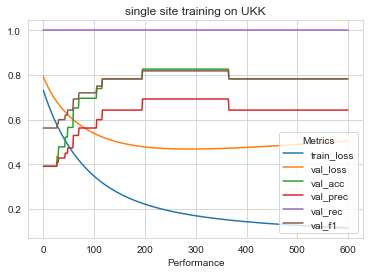

single site training on UKK
test loss 0.4488320052623749
test_acc 0.7894736842105263
test_prec 0.6412213740458015
test_rec 0.9882352941176471
test_f1 0.7777777777777778




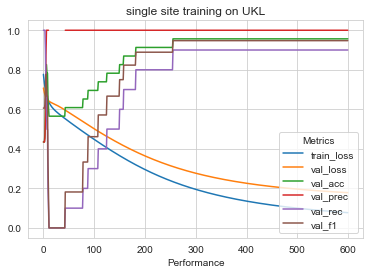

single site training on UKL
test loss 0.1857776641845703
test_acc 0.9517543859649122
test_prec 0.9868421052631579
test_rec 0.8823529411764706
test_f1 0.9316770186335404




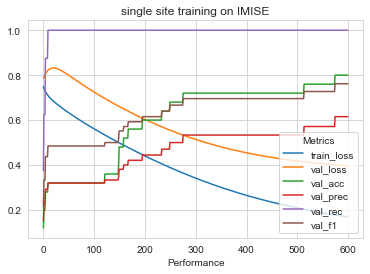

single site training on IMISE
test loss 0.3946767747402191
test_acc 0.793859649122807
test_prec 0.6461538461538462
test_rec 0.9882352941176471
test_f1 0.7813953488372093




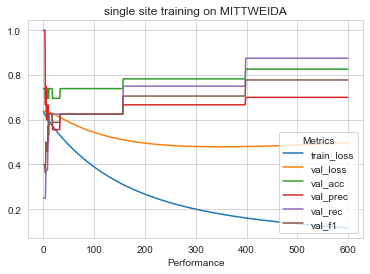

single site training on MITTWEIDA
test loss 0.3490561842918396
test_acc 0.8640350877192983
test_prec 0.75
test_rec 0.9529411764705882
test_f1 0.8393782383419689




In [12]:
input_dim = 30
hidden_dim = 64
num_classes = 2

learning_rate = 0.01
weight_decay = 0.0005
num_epochs = 600

criterion = nn.CrossEntropyLoss()

for idx in range(len(station_list)):
    
    scaler = StandardScaler()
    df_X = station_dfs[idx][X_FEATURES]
    df_Y = station_dfs[idx][Y_FEATURE]
    df_X = scaler.fit_transform(df_X)
    df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
    df_Y = df_Y.to_numpy()
    _, X_val, _, y_val = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)
    
    X_train = synthetic_dfs[idx][X_FEATURES]
    y_train = synthetic_dfs[idx][Y_FEATURE]
    X_train = scaler.fit_transform(X_train)
    y_train.replace(to_replace=dict(M=1, B=0), inplace=True)
    y_train = y_train.to_numpy()
    
    model = LogisticRegression(input_dim, hidden_dim, num_classes)
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    losses = []
    val_losses = []
    val_accs = []
    val_precs = []
    val_recs = []
    val_f1s = []
    for epoch in range(num_epochs):
        perm = np.arange(X_train.shape[0])
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        loss = train(X_train, y_train, model, criterion, optim)
        val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_val, y_val, model, criterion)
        losses.append(loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_precs.append(val_precesion)
        val_recs.append(val_recall)
        val_f1s.append(val_f1_score)
    test_loss, test_acc, test_precesion, test_recall, test_f1_score = valid(X_test, y_test, model, criterion)
    plt.figure()
    plt.plot(losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.plot(val_accs, label="val_acc")
    plt.plot(val_precs, label="val_prec")
    plt.plot(val_recs, label="val_rec")
    plt.plot(val_f1s, label="val_f1")
    plt.legend(title="Metrics", loc="lower right")
    plt.title("single site training on {}".format(station_list[idx].upper())),
    plt.xlabel("Epoch")
    plt.xlabel("Performance")
    plt.show()
    print("single site training on {}".format(station_list[idx].upper()))
    print("test loss", test_loss)
    print("test_acc", test_acc)
    print("test_prec", test_precesion)
    print("test_rec", test_recall)
    print("test_f1", test_f1_score)
    print("\n")

## Institutional Incremental Learning

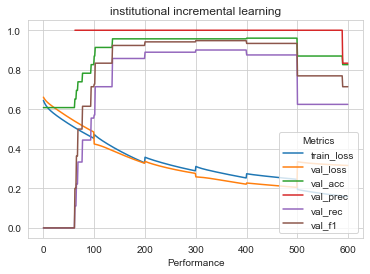

institutional incremental learning
test loss 0.1739557832479477
test_acc 0.9473684210526315
test_prec 0.9506172839506173
test_rec 0.9058823529411765
test_f1 0.927710843373494




In [13]:
input_dim = 30
hidden_dim = 64
num_classes = 2

learning_rate = 0.01
weight_decay = 0.0005
num_epochs = 100

criterion = nn.CrossEntropyLoss()
model = LogisticRegression(input_dim, hidden_dim, num_classes)

losses = []
val_losses = []
val_accs = []
val_precs = []
val_recs = []
val_f1s = []
for idx in range(len(station_list)):
    optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scaler = StandardScaler()
    df_X = station_dfs[idx][X_FEATURES]
    df_Y = station_dfs[idx][Y_FEATURE]
    df_X = scaler.fit_transform(df_X)
    df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
    df_Y = df_Y.to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)
    for epoch in range(num_epochs):
        perm = np.arange(X_train.shape[0])
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        loss = train(X_train, y_train, model, criterion, optim)
        val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_val, y_val, model, criterion)
        losses.append(loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_precs.append(val_precesion)
        val_recs.append(val_recall)
        val_f1s.append(val_f1_score)

test_loss, test_acc, test_precesion, test_recall, test_f1_score = valid(X_test, y_test, model, criterion)    
plt.figure()
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.plot(val_accs, label="val_acc")
plt.plot(val_precs, label="val_prec")
plt.plot(val_recs, label="val_rec")
plt.plot(val_f1s, label="val_f1")
plt.legend(title="Metrics", loc="lower right")
plt.title("institutional incremental learning")
plt.xlabel("Epoch")
plt.xlabel("Performance")
plt.show()
print("institutional incremental learning")
print("test loss", test_loss)
print("test_acc", test_acc)
print("test_prec", test_precesion)
print("test_rec", test_recall)
print("test_f1", test_f1_score)
print("\n")
    

## Cyclic Institutional Increamental Learning (CIIL)

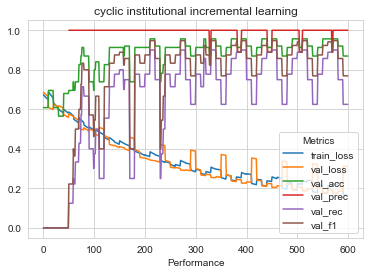

cyclic institutional incremental learning
test loss 0.18104304373264313
test_acc 0.9517543859649122
test_prec 0.9743589743589743
test_rec 0.8941176470588236
test_f1 0.9325153374233128




In [14]:
input_dim = 30
hidden_dim = 64
num_classes = 2

learning_rate = 0.01
weight_decay = 0.0005
num_cycles = 10
num_epochs = 10

criterion = nn.CrossEntropyLoss()
model = LogisticRegression(input_dim, hidden_dim, num_classes)

losses = []
val_losses = []
val_accs = []
val_precs = []
val_recs = []
val_f1s = []
for cycle in range(num_cycles):
    for idx in range(len(station_list)):
        optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scaler = StandardScaler()
        df_X = station_dfs[idx][X_FEATURES]
        df_Y = station_dfs[idx][Y_FEATURE]
        df_X = scaler.fit_transform(df_X)
        df_Y.replace(to_replace=dict(M=1, B=0), inplace=True)
        df_Y = df_Y.to_numpy()
        X_train, X_val, y_train, y_val = train_test_split(df_X, df_Y, test_size=0.4, random_state=42)
        for epoch in range(num_epochs):
            perm = np.arange(X_train.shape[0])
            np.random.shuffle(perm)
            X_train = X_train[perm]
            y_train = y_train[perm]
            loss = train(X_train, y_train, model, criterion, optim)
            val_loss, val_acc, val_precesion, val_recall, val_f1_score = valid(X_val, y_val, model, criterion)
            losses.append(loss)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_precs.append(val_precesion)
            val_recs.append(val_recall)
            val_f1s.append(val_f1_score)

test_loss, test_acc, test_precesion, test_recall, test_f1_score = valid(X_test, y_test, model, criterion)    
plt.figure()
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.plot(val_accs, label="val_acc")
plt.plot(val_precs, label="val_prec")
plt.plot(val_recs, label="val_rec")
plt.plot(val_f1s, label="val_f1")
plt.legend(title="Metrics", loc="lower right")
plt.title("cyclic institutional incremental learning"),
plt.xlabel("Epoch")
plt.xlabel("Performance")
plt.show()
print("cyclic institutional incremental learning")
print("test loss", test_loss)
print("test_acc", test_acc)
print("test_prec", test_precesion)
print("test_rec", test_recall)
print("test_f1", test_f1_score)
print("\n")
    